***
# $\mathbf{\text{Sentiment Analysis}}$<br>
***


### The analysis is to study Amazon pet supplies reviews from customers and try to predict whether a review is positive or negative. The dataset contains more than 200K reviews with the number of upvotes & total votes to those comments, in this case, is the 'Helpfulness' feature.

## Table of Contents

<br>
- Data pre-processing for sentiment analysis
<br>
<br>
- Rating prediction

    - Logistic regression model on word count
    - Logistic regression model on TFIDF
    - Logistic regression model on TFIDF + ngram

<br>
- Upvote prediction

    - Data preview
    - Resampling due to imbalanced data
    - Logistic regression model on word count
    - Logistic regression model on TFIDF + ngram
    - Study on non-context features
<br>
- In-depth study on user behaviour

# Importing Libraries

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import svm

import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ngrams

from itertools import chain
from wordcloud import WordCloud
from fractions import Fraction

import re
import warnings
warnings.filterwarnings('ignore')

# Pre-processing Data

In [2]:
# Import dataset from the previous converting step
df = pd.read_csv('Pet_Supplies.csv')
df.head()

,productId,title,price,userId,profileName,helpfulness,score,time,summary,text
0,B000O1CRYW,Orbee Tuff Ball Orange - SMALL,6.95,A2FEQ9XL6ML51C,Just an everyday Dad,1/1,5.0,1286064000,"Little Ball, for Little Dogs...","Great Toy, hard to find! We get ours online h..."
1,B000O1CRYW,Orbee Tuff Ball Orange - SMALL,6.95,A183LI95B2WNUQ,"V. J. Mcmillen ""vmcmillen""",1/1,5.0,1230249600,glow ball,I have bought several of these small Orbee Tu...
2,B000O1CRYW,Orbee Tuff Ball Orange - SMALL,6.95,A1LSSENM0XIQQR,gcoronado4,0/0,3.0,1309046400,Too Big,It is a quality ball but the small is still t...
3,B000O1CRYW,Orbee Tuff Ball Orange - SMALL,6.95,A2E5PZE1PZVK38,jerry,0/0,5.0,1308873600,no good,I gave it 5 stars because my little dog had s...
4,B0002ARHAE,Kent Marine Pro-Clear Freshwater Clarifier,3.73,A3PXLJE4OPIQTY,"M. Thomas ""sea_anemone""",0/0,5.0,1356912000,Best clarifier ever,I've used many products to try and help the w...


## Data Preparation and Cleaning

#### 1. Directly check for 'unknown' userId and drop the duplicates.
#### 2. Impute missing values. 
#### 3. Drop the unnecessary feature.
#### 4. Rename the features.
#### 5. Convert time to date format by creating a new feature.
#### 6. Find all duplicate entries (e.g., keep the latest review if the reviewer has reviewed the same product more than once).
#### 7. Check for null values remove entries where both summary and text are nan.
#### 8. Find all the URLs in summary and text and replace them with '' if any.
#### 9. Combine Text and Summary features and drop the Summary column.

In [3]:
# Check if there is unknown userId
df[df['userId'].str.contains('unknown', case=False, na=False)]

,productId,title,price,userId,profileName,helpfulness,score,time,summary,text
129,B0002ARHHW,Coastal Holt Dog Walking Collar,8.03,unknown,unknown,15/15,3.0,1272758400,Halti Sizing,Service from seller was excellent. Halti sizi...
918,B0002XUM3A,Kyjen Holiday Gingerbread Man Dog Toy,unknown,unknown,unknown,0/2,1.0,1099180800,OOOOOh not again,My dog ate the hole thing the second we gave ...
1075,B0009YF3G8,Petmate Le Bistro Waterer with Microban,unknown,unknown,unknown,0/0,4.0,1208563200,Pretty good,I've had this product a few months now (for o...
2481,B00076NS1U,D.A.P. Dog Appeasing Pheromone Spray (60ml),23.41,unknown,unknown,3/3,5.0,1271808000,No Joke It Works For My Dog,My poor dog Chuck suffers from several noise ...
2806,B0002DJG0U,Super Pet Critter Litter,8.99,unknown,unknown,0/9,1.0,1293840000,epic fail,"my gerbils used it as a tunnel, as well as so..."
...,...,...,...,...,...,...,...,...,...,...
214224,B0002IEOJI,Quail Recall Pen,unknown,unknown,unknown,2/2,5.0,1164326400,this wonderful quail recall pen catches quail...,i got this for christmas and it caught a whol...
214225,B0002IEOJI,Quail Recall Pen,unknown,unknown,unknown,1/2,5.0,1164326400,catches quail better than a snap trap!,i got this for christmas and it caught a whol...
214745,B00061MPH4,Mega-Tek Rebuilder Paw Pads Pet Conditioner -...,11.04,unknown,unknown,9/9,5.0,1242604800,AWESOME!!!!,I've now been using Mega Tek for about two mo...
215833,B000FUJBLY,Pet Buddies Catnip Creatures Cat Toy,unknown,unknown,unknown,0/0,4.0,1167782400,catnip,I love this because my cat allways plays with...


In [4]:
# Remove unknown userId
df = df[df['userId'].str.contains('unknown') == False]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216613 entries, 0 to 217169
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   productId    216613 non-null  object 
 1   title        216586 non-null  object 
 2   price        216613 non-null  object 
 3   userId       216613 non-null  object 
 4   profileName  216613 non-null  object 
 5   helpfulness  216613 non-null  object 
 6   score        216613 non-null  float64
 7   time         216613 non-null  int64  
 8   summary      216613 non-null  object 
 9   text         216613 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 18.2+ MB


In [6]:
# Impute missing values of 'title' column
df['title'] = df['title'].fillna(value = 'unknown')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216613 entries, 0 to 217169
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   productId    216613 non-null  object 
 1   title        216613 non-null  object 
 2   price        216613 non-null  object 
 3   userId       216613 non-null  object 
 4   profileName  216613 non-null  object 
 5   helpfulness  216613 non-null  object 
 6   score        216613 non-null  float64
 7   time         216613 non-null  int64  
 8   summary      216613 non-null  object 
 9   text         216613 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 18.2+ MB


In [8]:
# Check unique value of score feature
df['score'].unique()

array([5., 3., 4., 2., 1.])

In [9]:
# Drop columns that are not required for analysis. Since there is a UserID feature, thus the profileName feature is not necessary.
df.drop(columns=['profileName'], inplace=True)

In [10]:
# Rename the columns
df.rename(columns = {'productId' : 'ProductID', 'title' : 'Title', 'price' : 'Price', 
                    'userId' : 'UserID', 'helpfulness' : 'Helpfulness', 'score' : 'Rating', 
                    'time' : 'Time', 'summary' : 'Summary', 'text' : 'Text'}, inplace=True)

In [11]:
# Convert Time to date format and add a column 'Date'
df['Date'] = pd.to_datetime(df['Time'], unit = 's')

In [12]:
# Drop Time column
df.drop(columns='Time', inplace=True)

In [13]:
# Sorting the rows by date, old reviews to latest reviews
df = df.sort_values(by = 'Date')

In [14]:
# Finding duplicates of one customer giving a review for the same product
df[df.duplicated(subset = ['ProductID', 'UserID'], keep = 'last')]

,ProductID,Title,Price,UserID,Helpfulness,Rating,Summary,Text,Date
163975,B00005RG3G,Fat Cat Crackler Mouse,unknown,A2E1EEGG2EBMNO,1/1,4.0,My cat loves their toys!,I bought my cat the moth crakler toy. He love...,2001-12-10
126163,B00006IV0M,LitterMaid LM 600 Self-Cleaning Litterbox,unknown,A1NOJYUVSLQZDE,3/6,4.0,Love my Littermaid!,"I love my Littermaid Litterbox! On the whole,...",2003-03-30
126159,B00006IV0M,LitterMaid LM 600 Self-Cleaning Litterbox,unknown,A1NOJYUVSLQZDE,4/5,4.0,Love my Littermaid!,"I love my Littermaid Litterbox! On the whole,...",2003-03-31
182991,B00005OU62,LitterMaid LM700 Self-Cleaning Automatic Litt...,unknown,A3HUL49SNY6Z02,0/0,5.0,"Now available in the UK, thank goodness!!!",Do cat owners really know how much their hous...,2003-05-16
142665,B00005MF9U,LitterMaid LM900 Mega Self-Cleaning Litter Box,unknown,A23LW4BQBFGQ5E,5/6,5.0,Highly recommend. I have had excellent results,I have had mine now for over 5 years and I ha...,2004-02-02
...,...,...,...,...,...,...,...,...,...
135055,B00028ZLDG,Panacur C Canine Dewormer,8.35,A10UB2CI8TRMK4,0/0,5.0,Awesome.,This product did the trick! I am happy and so...,2013-01-24
135091,B00028ZLDG,Panacur C Canine Dewormer,8.35,A10UB2CI8TRMK4,1/1,5.0,Great.,"Good product, worked very well. I was very ha...",2013-01-24
162843,B000KH9S88,Zoo Med Avian Sun 5.0 UVB Bulb,21.99,A6G5EGY3DT9M6,0/0,5.0,Stopped My Birds Winter Feather Picking,My mini-macaw (Hahn's macaw) loves to perch u...,2013-01-28
62506,B000PU34TO,Horseman's Pride Jolly Ball,unknown,A1W97Q4N2K20VD,0/0,5.0,best dog toy ever,even though the handle was chewed off instant...,2013-02-05


In [15]:
# Removing the duplicates by keeping the latest review (the last value found)
df.drop_duplicates(subset = ['ProductID', 'UserID'], keep ='last', inplace = True)

In [16]:
df

,ProductID,Title,Price,UserID,Helpfulness,Rating,Summary,Text,Date
122323,B00004RA8Q,Perky-Pet 8 oz Glass Hummingbird Feeder 203CP,unknown,A84J7PUWOC138,13/15,2.0,Hard to clean...,I had this hummingbird feeder. The birds used...,2000-04-06
122328,B00004RA8Q,Perky-Pet 8 oz Glass Hummingbird Feeder 203CP,unknown,A31IXXJK4YSEZ2,1/3,4.0,"Great, but remove the bee guards",I had trouble getting the hummers to pay much...,2000-05-17
122326,B00004RA8Q,Perky-Pet 8 oz Glass Hummingbird Feeder 203CP,unknown,A33BFDLGPRGSC9,6/8,5.0,The Only Feeder I Use,Don't understand the problems others mention....,2000-05-28
122336,B00004RA94,Birdscapes 350 Squirrel-Be-Gone Wild Bird Feeder,24.99,AM7TDN3SSPH6W,4/6,5.0,Birds Love It,I have used this product several times. The b...,2000-06-14
122517,B00004RA91,Perky Pet Original Instant Nectar - 8-Ounces,3.99,A2FWAQS2ZYELDY,8/10,5.0,Hummingbird Nectar,I have used this brand for a long time now an...,2000-07-07
...,...,...,...,...,...,...,...,...,...
111236,B0007D3188,"DermaPet"" Benzoyl Peroxide Plus Shampoo (Derm...",16.40,A22E359W5DJMSL,0/0,5.0,Recommend for mild mange,My dog's coat is so shiny and healthy looking...,2013-03-03
19011,B000ETLOAM,Nutri-Vet Hip & Joint Peanut Butter Large Dog...,15.59,A1OMXVXXP07F05,0/0,4.0,Dog loves them!,My 12 year old Collie loves these bones! Our ...,2013-03-03
46234,B0009YHU6Y,"Tetra 77847 Whisper Air Pump, upto 20-Gallon",10.13,A1ZDOVDRT43AAH,0/0,5.0,Air Pump,I am impressed with the the looks and quietne...,2013-03-03
185681,B00076HUB4,Pill Gun,1.42,A26DHEDK8W67O5,0/0,5.0,Worked great. No bitten fingers.,My cat will not take pills and you almost los...,2013-03-03


## Special case

In [17]:
# Check if both Summary and Text are NaN, then delete those rows
cols = ['Text', 'Summary']
df[df[cols].isnull().all(axis=1)]

,ProductID,Title,Price,UserID,Helpfulness,Rating,Summary,Text,Date


In [18]:
# Check if Text feature contains URL
df['Summary'][df['Summary'].str.match(pat = '(https)|(http)|(www.)', na = False)]

Series([], Name: Summary, dtype: object)

In [19]:
# Combine both summary and text
df['Text'] = df[['Text', 'Summary']].astype(str).apply(lambda x: ' //'.join(x), axis = 1)

In [20]:
# Reset index
df.reset_index(inplace=True, drop=True)
df

,ProductID,Title,Price,UserID,Helpfulness,Rating,Summary,Text,Date
0,B00004RA8Q,Perky-Pet 8 oz Glass Hummingbird Feeder 203CP,unknown,A84J7PUWOC138,13/15,2.0,Hard to clean...,I had this hummingbird feeder. The birds used...,2000-04-06
1,B00004RA8Q,Perky-Pet 8 oz Glass Hummingbird Feeder 203CP,unknown,A31IXXJK4YSEZ2,1/3,4.0,"Great, but remove the bee guards",I had trouble getting the hummers to pay much...,2000-05-17
2,B00004RA8Q,Perky-Pet 8 oz Glass Hummingbird Feeder 203CP,unknown,A33BFDLGPRGSC9,6/8,5.0,The Only Feeder I Use,Don't understand the problems others mention....,2000-05-28
3,B00004RA94,Birdscapes 350 Squirrel-Be-Gone Wild Bird Feeder,24.99,AM7TDN3SSPH6W,4/6,5.0,Birds Love It,I have used this product several times. The b...,2000-06-14
4,B00004RA91,Perky Pet Original Instant Nectar - 8-Ounces,3.99,A2FWAQS2ZYELDY,8/10,5.0,Hummingbird Nectar,I have used this brand for a long time now an...,2000-07-07
...,...,...,...,...,...,...,...,...,...
215239,B0007D3188,"DermaPet"" Benzoyl Peroxide Plus Shampoo (Derm...",16.40,A22E359W5DJMSL,0/0,5.0,Recommend for mild mange,My dog's coat is so shiny and healthy looking...,2013-03-03
215240,B000ETLOAM,Nutri-Vet Hip & Joint Peanut Butter Large Dog...,15.59,A1OMXVXXP07F05,0/0,4.0,Dog loves them!,My 12 year old Collie loves these bones! Our ...,2013-03-03
215241,B0009YHU6Y,"Tetra 77847 Whisper Air Pump, upto 20-Gallon",10.13,A1ZDOVDRT43AAH,0/0,5.0,Air Pump,I am impressed with the the looks and quietne...,2013-03-03
215242,B00076HUB4,Pill Gun,1.42,A26DHEDK8W67O5,0/0,5.0,Worked great. No bitten fingers.,My cat will not take pills and you almost los...,2013-03-03


In [21]:
# Use regex for removing URL in any form

import re

def remove_urls (url_text):
    url_text = re.sub(r'(https|http|www)(://|\.)(\w|\.|\/|\?|\=|\&|\%|[-]|\///)*\b', '', url_text, flags=re.MULTILINE)
    return(url_text)

In [22]:
# Get all the indexes of Text which has URL
url_index = df[df['Text'].str.match(pat = '(https)|(http)|(www.)')].index
url_index

Int64Index([], dtype='int64')

In [23]:
# See a data example
df['Text'][0]

' I had this hummingbird feeder. The birds used it, but the feeder was very difficult to keep clean. It tended to get mold in all those little nooks and crannies. In hot weather, you need to change the sugar water every 3-4 days. Choose a hummingbird feeder that is easy to clean. // Hard to clean...'

In [24]:
# Separating Helpfulness column values and keep it to the new columns
df[['Upvote', 'Total']] = df['Helpfulness'].str.split('/', expand=True)

# Change datatypes
df[['Upvote', 'Total']] = df[['Upvote', 'Total']].astype('int64')

In [25]:
# Adding the upvote percentage feature for additional metrics and binning it into 6 categories
df['Upvote_Percentage'] = np.where(df['Total'] > 0, df['Upvote'] / df['Total'], -1)
df['Upvote_Percentage'] = pd.cut(df['Upvote_Percentage'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
df['ID'] = df.index;
df

,ProductID,Title,Price,UserID,Helpfulness,Rating,Summary,Text,Date,Upvote,Total,Upvote_Percentage,ID
0,B00004RA8Q,Perky-Pet 8 oz Glass Hummingbird Feeder 203CP,unknown,A84J7PUWOC138,13/15,2.0,Hard to clean...,I had this hummingbird feeder. The birds used...,2000-04-06,13,15,80-100%,0
1,B00004RA8Q,Perky-Pet 8 oz Glass Hummingbird Feeder 203CP,unknown,A31IXXJK4YSEZ2,1/3,4.0,"Great, but remove the bee guards",I had trouble getting the hummers to pay much...,2000-05-17,1,3,20-40%,1
2,B00004RA8Q,Perky-Pet 8 oz Glass Hummingbird Feeder 203CP,unknown,A33BFDLGPRGSC9,6/8,5.0,The Only Feeder I Use,Don't understand the problems others mention....,2000-05-28,6,8,60-80%,2
3,B00004RA94,Birdscapes 350 Squirrel-Be-Gone Wild Bird Feeder,24.99,AM7TDN3SSPH6W,4/6,5.0,Birds Love It,I have used this product several times. The b...,2000-06-14,4,6,60-80%,3
4,B00004RA91,Perky Pet Original Instant Nectar - 8-Ounces,3.99,A2FWAQS2ZYELDY,8/10,5.0,Hummingbird Nectar,I have used this brand for a long time now an...,2000-07-07,8,10,60-80%,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215239,B0007D3188,"DermaPet"" Benzoyl Peroxide Plus Shampoo (Derm...",16.40,A22E359W5DJMSL,0/0,5.0,Recommend for mild mange,My dog's coat is so shiny and healthy looking...,2013-03-03,0,0,Empty,215239
215240,B000ETLOAM,Nutri-Vet Hip & Joint Peanut Butter Large Dog...,15.59,A1OMXVXXP07F05,0/0,4.0,Dog loves them!,My 12 year old Collie loves these bones! Our ...,2013-03-03,0,0,Empty,215240
215241,B0009YHU6Y,"Tetra 77847 Whisper Air Pump, upto 20-Gallon",10.13,A1ZDOVDRT43AAH,0/0,5.0,Air Pump,I am impressed with the the looks and quietne...,2013-03-03,0,0,Empty,215241
215242,B00076HUB4,Pill Gun,1.42,A26DHEDK8W67O5,0/0,5.0,Worked great. No bitten fingers.,My cat will not take pills and you almost los...,2013-03-03,0,0,Empty,215242


In [26]:
# Counting the number of each of the categories
df_grouping = df.groupby(['Rating', 'Upvote_Percentage']).agg({'ID': 'count'})
df_grouping

ID
Rating Upvote_Percentage       
1.0    Empty              10368
       0-20%                434
       20-40%              1059
       40-60%              1947
       60-80%              2058
       80-100%             7490
2.0    Empty               6912
       0-20%                103
       20-40%               318
       40-60%               777
       60-80%               705
       80-100%             4218
3.0    Empty               9797
       0-20%                 78
       20-40%               244
       40-60%               718
       60-80%               729
       80-100%             5444
4.0    Empty              20453
       0-20%                 46
       20-40%               131
       40-60%               661
       60-80%               740
       80-100%            12403
5.0    Empty              79359
       0-20%                 75
       20-40%               299
       40-60%              1899
       60-80%              2194
       80-100%            43585

In [27]:
# Unstacking the grouping and transposing it
df_grouping = df_grouping.unstack()

df_grouping.columns = df_grouping.columns.get_level_values(1)
df_grouping

Upvote_Percentage,Empty,0-20%,20-40%,40-60%,60-80%,80-100%
Rating,,,,,,
1.0,10368,434,1059,1947,2058,7490
2.0,6912,103,318,777,705,4218
3.0,9797,78,244,718,729,5444
4.0,20453,46,131,661,740,12403
5.0,79359,75,299,1899,2194,43585


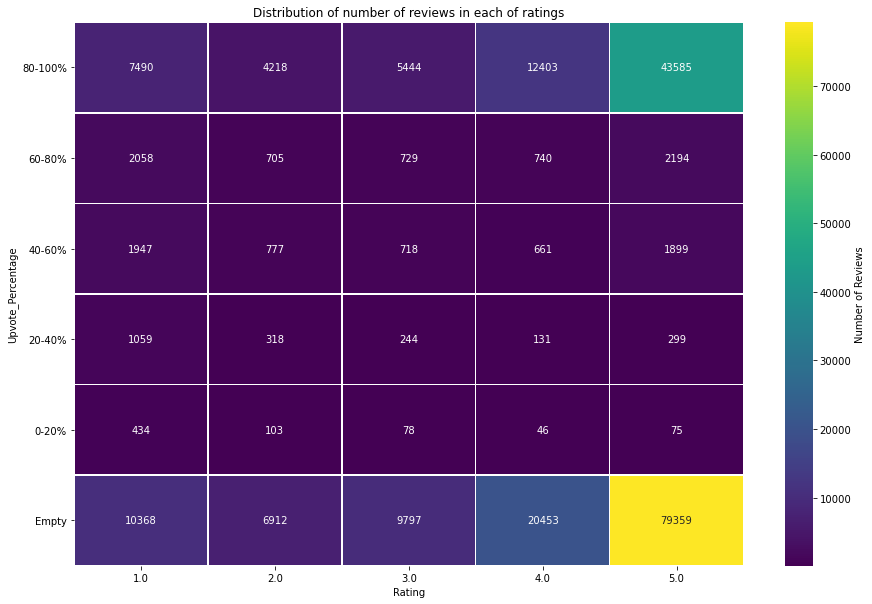

In [28]:
# Plot the grouping result
fig = plt.figure(figsize=(15,10))
sns.heatmap(df_grouping[df_grouping.columns[::-1]].T, cmap = 'viridis', linewidths=.5, annot = True, fmt = 'd', cbar_kws={'label': 'Number of Reviews'})
plt.yticks(rotation=0)
plt.title('Distribution of number of reviews in each of ratings');

#### According to the plot above, it can be seen that the 5.0 rating outnumbered other ratings. Thus the ratings and reviews are skewed towards positive.

# Rating Prediction


### Removing the rating of 3 (neutral), and convert the remaining ratings into binary:
<br>
 Class 1: positive for rating > 3
 <br>
 Class 0: negative for rating < 3


In [29]:
df['Rating'].unique()

array([2., 4., 5., 1., 3.])

In [30]:
# Drop the rating of 3 and converting the remaining ratings
df_sentiment = df[df['Rating'] != 3]
X = df_sentiment['Text']

y_bin = {1:0, 2:0, 4:1, 5:1}
y = df_sentiment['Rating'].map(y_bin)

In [31]:
df_sentiment['Rating'].unique()

array([2., 4., 5., 1.])

## Performing logistic regression on word count

In [32]:
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model, clf_model, coef_show=1):
    
    X_c = model.fit_transform(X)
    print('Number of features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=42)
    print('Number of train records: {}'.format(X_train.shape[0]))
    print('Number of test records: {}'.format(X_test.shape[0]))
    
    
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('Top 20 positive')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('Top 20 negative')        
        print(coeff_df.tail(20).to_string(index=False))
    
    
text_fit(X, y, c, LogisticRegression())

Number of features: 78374
Number of train records: 148675
Number of test records: 49559
Model Accuracy: 0.9291349704392744

Top 20 positive
       Word  Coefficient
      beats     2.859895
      saves     2.800178
  excellent     2.612742
 pleasantly     2.473665
  ingenious     2.445946
  lifesaver     2.422052
     sooner     2.381817
      saved     2.342431
  skeptical     2.245780
        tan     2.241425
  fantastic     2.240103
 prescribed     2.186226
    amazing     2.169462
outstanding     2.155514
      notch     2.089191
   pleasure     2.061811
   downside     2.052266
    benebac     2.051774
    awesome     2.048718
 impressive     2.043316

Top 20 negative
          Word  Coefficient
     deceptive    -2.134482
          bust    -2.134855
  dissapointed    -2.158350
        theory    -2.161634
        poorly    -2.181541
     proceeded    -2.193198
     substance    -2.202341
           4lb    -2.230056
      rejected    -2.303709
disappointment    -2.320090
   ineffec

### Despite the model accuracy is around 93%, some of both positive and negative words are not meaningful, for instance benebac, eh, 4lb.

In [33]:
y.value_counts()

1    161845
0     36389
Name: Rating, dtype: int64

### Check the base line model accuracy in predicting with majority class (positive class)

In [34]:
text_fit(X, y, c, DummyClassifier(), 0)

Number of features: 78374
Number of train records: 148675
Number of test records: 49559
Model Accuracy: 0.8149478399483444


# Logistic regression model on TF-IDF

In [35]:
tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, LogisticRegression())

Number of features: 78374
Number of train records: 148675
Number of test records: 49559
Model Accuracy: 0.9298008434391332

Top 20 positive
     Word  Coefficient
    great    14.761118
     love    12.642702
    loves    12.365373
     best    11.383140
excellent    10.291257
    works     9.471431
  perfect     8.924779
   highly     8.763932
     easy     8.049886
  amazing     7.946701
  awesome     7.788535
    happy     6.485982
 favorite     6.315485
wonderful     6.081543
perfectly     6.037567
  pleased     6.037142
     nice     5.833576
fantastic     5.702610
    helps     5.572664
     good     5.419576

Top 20 negative
         Word  Coefficient
       refund    -5.259239
     terrible    -5.262249
        worse    -5.270412
        maybe    -5.294965
    dangerous    -5.462084
       beware    -5.597586
       poorly    -5.681252
         junk    -5.797592
       return    -5.851218
        money    -6.008020
unfortunately    -6.089101
     horrible    -6.098501
        w

### Applying TF-IDF results in roughly the same model accuracy, around 93%. However, both top 20 positive and negative words are much more sense and have a higher coefficient magnitude than the previous result. 


# Logistic regression model on TF-IDF + n-gram

In [36]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2), stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

Number of features: 2568023
Number of train records: 148675
Number of test records: 49559
Model Accuracy: 0.9272180633184689

Top 20 positive
            Word  Coefficient
           great    20.248615
            love    17.552123
           loves    16.174376
            best    14.643622
           works    13.844220
         perfect    11.587686
            easy    11.434610
       excellent    11.359687
           happy     8.637919
         awesome     8.597755
         amazing     8.547821
   great product     8.471724
            nice     8.062294
          highly     7.628532
highly recommend     6.930537
        favorite     6.926411
         pleased     6.915207
            good     6.906176
       wonderful     6.698356
           keeps     6.467631

Top 20 negative
         Word  Coefficient
   doesn work    -6.501355
         didn    -6.568124
         junk    -6.582197
     returned    -6.729064
        worst    -6.976879
      minutes    -6.998144
         idea    -7.09

### The model accuracy is a bit decrease to 92.7%. However, using n-gram allows the model to understand the phrase like 'highly recommend' and 'waste money'.

# Upvote Prediction

To see whether any pattern can be found in the unpopular/downvote comments by users. 

Firstly, the neutral votes (rating 3) needs to be rid of.

In [37]:
# Remove the neutral votes

df_sentiment = df_sentiment[df_sentiment['Rating'] == 5]
df_sentiment = df_sentiment[df_sentiment['Upvote_Percentage'].isin(['0-20%', '20-40%', '60-80%', '80-100%'])]
df_sentiment.shape
print(df_sentiment)
X = df_sentiment['Text']
y_bin = {'0-20%': 0, '20-40%': 0, '60-80%': 1, '80-100%': 1}
y = df_sentiment['Upvote_Percentage'].map(y_bin)

print('Class distribution: ')
print(y.value_counts())

          ProductID                                              Title  \
2        B00004RA8Q      Perky-Pet 8 oz Glass Hummingbird Feeder 203CP   
3        B00004RA94   Birdscapes 350 Squirrel-Be-Gone Wild Bird Feeder   
4        B00004RA91       Perky Pet Original Instant Nectar - 8-Ounces   
8        B00004RA91       Perky Pet Original Instant Nectar - 8-Ounces   
9        B000035X8X                          482 HENRY NORWEGIAN FJORD   
...             ...                                                ...   
214135   B000BQN9LA      Coolaroo Elevated Pet Bed with Knitted Fabric   
214601   B0000AH3RR   Purina One Cat Smartblend Salmon and Tuna Cat...   
214688   B000CD8BRY   Glucosamine Chondroitin for Dogs - Hip & Join...   
214856   B000J2PGE4                    Zanies Laser Beam Mouse Cat Toy   
214983   B000FH708I   Comfort Zone with Feliway for Cats Diffuser a...   

           Price           UserID Helpfulness  Rating  \
2        unknown   A33BFDLGPRGSC9         6/8     5.0 

### It can be observed that the upvotes are skewed towards positive side. To handle it, resampling the data has to be performed. 

In [38]:
# Resampling the data

df_s = pd.DataFrame(data = [X, y]).T

Downvote_records = len(df_s[df_s['Upvote_Percentage'] == 0])
Downvote_indices = np.array(df_s[df_s['Upvote_Percentage'] == 0].index)

Upvote_indices = df_s[df_s['Upvote_Percentage'] == 1].index

random_upvote_indices = np.random.choice(Upvote_indices, Downvote_records, replace = False)
random_upvote_indices = np.array(random_upvote_indices)

under_sample_indices = np.concatenate([Downvote_indices, random_upvote_indices])

under_sample_data = df_s.loc[under_sample_indices, :]
X_u = under_sample_data['Text']
under_sample_data['Upvote_Percentage'] = under_sample_data['Upvote_Percentage'].astype(int)
y_u = under_sample_data['Upvote_Percentage']


print("Percentage of upvote transactions:", len(under_sample_data[under_sample_data['Upvote_Percentage'] == 1])/len(under_sample_data))
print("Percentage of downvote transactions:", len(under_sample_data[under_sample_data['Upvote_Percentage'] == 0])/len(under_sample_data))
print("Total number of records in resampled data:", len(under_sample_data))

Percentage of upvote transactions: 0.5
Percentage of downvote transactions: 0.5
Total number of records in resampled data: 748


## Similar operations as above are performed on the resampled data to measure accuracy of the model

# Logistic regression model on word count

In [39]:
c = CountVectorizer(stop_words = 'english')

text_fit(X_u, y_u, c, LogisticRegression())

Number of features: 5889
Number of train records: 561
Number of test records: 187
Model Accuracy: 0.6631016042780749

Top 20 positive
   Word  Coefficient
   coat     0.941001
  keeps     0.920849
    bed     0.884508
 length     0.733682
   play     0.729367
  going     0.724406
 months     0.719072
  loves     0.688043
control     0.661576
 worked     0.654749
  crate     0.642498
  think     0.636581
   nail     0.598562
 bigger     0.597521
    way     0.589693
  birds     0.587107
    set     0.577750
miracle     0.573047
  power     0.572371
    oil     0.565643

Top 20 negative
      Word  Coefficient
      sure    -0.452017
     betta    -0.453233
      bowl    -0.458025
  products    -0.466904
     teeth    -0.467174
    priced    -0.472809
 delivered    -0.506811
    filter    -0.527906
  delivery    -0.533247
      cube    -0.558748
     using    -0.563025
      cage    -0.578959
      nice    -0.579477
   arrived    -0.589671
chinchilla    -0.596748
     value    -0.672044


### The coefficients are really small and the words mostly does not represent the sentiment.

# Logistic regression model on TF-IDF + n-gram

In [40]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2), stop_words = 'english')
text_fit(X_u, y_u, tfidf_n, LogisticRegression())

Number of features: 29662
Number of train records: 561
Number of test records: 187
Model Accuracy: 0.6577540106951871

Top 20 positive
      Word  Coefficient
       bed     1.051891
       toy     0.769071
      coat     0.757049
      play     0.706264
        ve     0.662711
     loves     0.640659
       dog     0.633455
     crate     0.623367
    months     0.568463
      like     0.538456
      dogs     0.534146
scratching     0.532489
     small     0.521035
   harness     0.515753
       cat     0.509999
     puppy     0.504827
      best     0.469995
       day     0.466204
     keeps     0.465717
     night     0.437628

Top 20 negative
      Word  Coefficient
     fence    -0.357717
   exactly    -0.360704
       muy    -0.369051
     betta    -0.389339
  delivery    -0.394402
     taste    -0.399627
     price    -0.412440
      know    -0.449363
chinchilla    -0.467249
     order    -0.489371
      fast    -0.507935
    filter    -0.508555
   service    -0.512781
      ta

### Unfortunately, the result is similar to the previous step.

# Study of non-contextual features

### Take a look at some examples of upvote and downvote comments

In [41]:
print('Downvote rating 5 comments examples:')
print(under_sample_data[under_sample_data['Upvote_Percentage']==0]['Text'].iloc[:100:20])

print('Upvote rating 5 comments examples:')
print(under_sample_data[under_sample_data['Upvote_Percentage']==1]['Text'].iloc[:100:20])

Downvote rating 5 comments examples:
83        This is my favorite feeder. We have three in ...
1460      This is a cute little toy for a little dog. I...
3343      A must have for your tank!! Save $$$ with the...
7108      We've had this now for about a month and I ca...
10747     Arrived very quickly - exactly as described. ...
Name: Text, dtype: object
Upvote rating 5 comments examples:
55329      been using this for years on our lab-chow; it...
15472      Mr. Herzher's pet residence provides a secure...
128427     I think Amazon has the best price for crates....
3017       My husband and I are parents to a one-year-ol...
10385      wanted to be able to take photos on our walks...
Name: Text, dtype: object


Above are the samples of the reviews that received downvotes and upvotes. The possible features have to be extracted from these reviews.

In [42]:
under_sample_data['word_count'] = under_sample_data['Text'].apply(lambda x: len(x.split()))
under_sample_data['capital_count'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c.isupper()))
under_sample_data['question_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '?'))
under_sample_data['exclamation_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '!'))
under_sample_data['punctuation'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c in punctuation))

print(under_sample_data.groupby('Upvote_Percentage').agg({'word_count': 'mean', 'capital_count': 'mean', 'question_mark': 'mean', 'exclamation_mark': 'mean', 'punctuation': 'mean'}).T)

X_num = under_sample_data[under_sample_data.columns.difference(['Upvote_Percentage', 'Text'])]
y_num = under_sample_data['Upvote_Percentage']

Upvote_Percentage          0           1
word_count         64.034759  103.532086
capital_count      15.315508   13.917112
question_mark       0.133690    0.056150
exclamation_mark    1.176471    1.262032
punctuation        12.366310   17.433155


## Training the models to predict upvotes

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y_num, random_state=42)

# Logistic regression
clf_lr = LogisticRegression().fit(X_train, y_train)
acc_lr = clf_lr.score(X_test, y_test)
print('Logistic Regression accuracy: {}'.format(acc_lr))

# SVM
clf_svm = svm.SVC().fit(X_train, y_train)
acc_svm = clf_svm.score(X_test, y_test)
print('SVM accuracy: {}'.format(acc_svm))

Logistic Regression accuracy: 0.6470588235294118
SVM accuracy: 0.6737967914438503


The models accuracy are slightly higher than the context features. It means that the possible features extracted is quite good to predict the target.

# Study of user behavior

The user behavior has to be analyzed to improve the model performance and understand the underlying reasons for the bad or good reviews. This also gives importance to the word choices of a user when giving reviews. This method can be expanded to all users also.

Firstly, take a look at the number of reviews each user has given.

In [44]:
df_user = df.groupby(['UserID']).agg({'Rating':['count', 'mean']})
df_user.columns = df_user.columns.get_level_values(1)

df_user.columns = ['Rating count', 'Rating mean']
df_user = df_user.sort_values(by = 'Rating count', ascending = False)
print(df_user)

                 Rating count  Rating mean
UserID                                    
 A11FX8HL2ANK6T            76     4.486842
 AS5CX8MSIW8NO             72     4.472222
 A3HPCRD9RX351S            58     4.413793
 A1Z54EM24Y40LL            54     3.944444
 AYQ8RLE0K6RU8             46     4.239130
...                       ...          ...
 A2DW5S010P9RT4             1     4.000000
 A2DW5O5FU3KOI9             1     3.000000
 A2DW34L7W6LX0B             1     1.000000
 A2DVZOPYDZBQYC             1     5.000000
 AZZZOVIBXHGDR              1     5.000000

[160495 rows x 2 columns]


### The user with UserID 'A11FX8HL2ANK6T' has given the most frequent reviews, with 76 reviews in total, and the average rating is 4.48.

Check the 'most frequent user' reviews distribution

In [45]:
# Check substring
df[df['UserID'].str.contains('A11FX8HL2ANK6T', regex=False)].count()


ProductID            76
Title                76
Price                76
UserID               76
Helpfulness          76
Rating               76
Summary              76
Text                 76
Date                 76
Upvote               76
Total                76
Upvote_Percentage    76
ID                   76
dtype: int64

In [46]:
df_user_check = df[df['UserID'].str.contains('A11FX8HL2ANK6T', regex=False)]['Rating']
df_user_check 

134372    5.0
135202    5.0
135708    5.0
136683    5.0
138068    5.0
         ... 
203076    5.0
203170    5.0
207011    5.0
207150    2.0
212965    5.0
Name: Rating, Length: 76, dtype: float64

In [47]:
from matplotlib import style
style.use('ggplot')

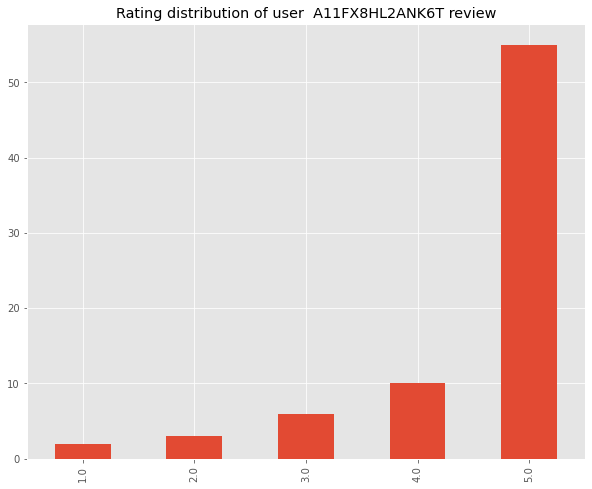

In [48]:
def plot_user(UserID):
    df_user_check = df[df['UserID'].str.contains(UserID, regex=False)]['Rating']
    df_user_id = df[df['UserID'].str.contains(UserID, regex=False)]['UserID']
    df_user_check_plot = df_user_check.value_counts(ascending=True)
    ax = df_user_check_plot.plot(kind = 'bar', figsize = (10, 8), title = 'Rating distribution of user {} review'.format(df_user_id.iloc[0]));


plot_user('A11FX8HL2ANK6T')

### According to the reviews distribution plot, this user prefer to give high rating. However, it is better to analyze a more neutral user.

In [49]:
# Checking a more neutral user
print(df_user[(df_user['Rating mean'] < 3.5) & (df_user['Rating mean'] > 2.5)].head())

                 Rating count  Rating mean
UserID                                    
 A100WO06OQR8BQ            27     3.185185
 AZ4IFJ01WKBTB             22     3.090909
 A22J92A80WI059            20     3.450000
 A3E752P9SWSH8S            19     3.052632
 AUF6C3UMM335Y             19     2.842105


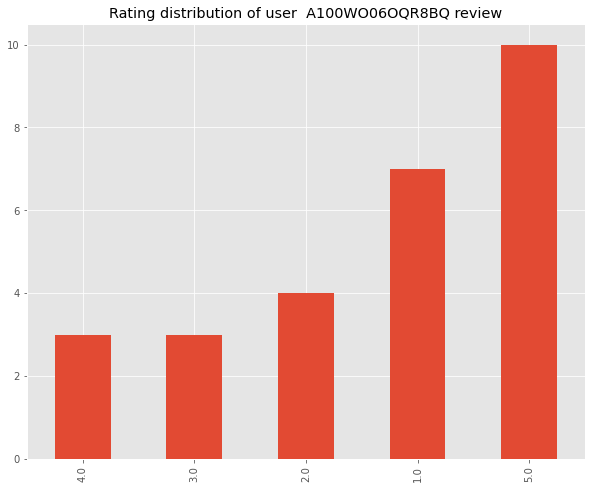

In [50]:
plot_user('A100WO06OQR8BQ') 

Most popular words used by the user for different ratings are observed. (2-grams and 3-grams are chosen for analysis)

In [51]:
def token_ngrams(score, benchmark, userid='all'):

    if userid != 'all':
        df_new = df[(df['UserID'].str.contains(userid)) & (df['Rating'] == score)]['Text']
    else:
        df_new = df[df['Rating'] == score]['Text']
        
    count = len(df_new)
    total_text = ' '.join(df_new)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w, 'v') for w in total_text]
    bigrams = ngrams(total_text, 2)
    trigrams = ngrams(total_text, 3)

    # Look at 2-gram and 3-gram together
    combine = chain(bigrams, trigrams)
    text = nltk.Text(combine)
    fdist = nltk.FreqDist(text)
    
    # Return only phrase occurs more than benchmark of reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

### Dig deeper into this user's reviews

In [52]:
# Rating 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1, 6):
    test = pd.DataFrame()
    d = token_ngrams(j, 0.03, 'A100WO06OQR8BQ')
    print('score {} reviews most popular 2-gram or 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular 2-gram or 3-gram:
                       Phrase  Count Occur %
0              (night, light)    4.0  57.14%
1                (flea, trap)    4.0  57.14%
13          (ship, overprice)    3.0  42.86%
24              (piece, junk)    3.0  42.86%
23   (delay, ship, overprice)    3.0  42.86%
..                        ...    ...     ...
201    (try, option, useless)    1.0  14.29%
200         (two, part, trap)    1.0  14.29%
199  (refill, time, purchase)    1.0  14.29%
198       (light, brightness)    1.0  14.29%
556              (use, small)    1.0  14.29%

[557 rows x 3 columns]
score 2 reviews most popular 2-gram or 3-gram:
                        Phrase  Count Occur %
0               (attach, show)    1.0   25.0%
69   (instructions, mine, car)    1.0   25.0%
80                  (car, n't)    1.0   25.0%
79     (prongs, suppose, make)    1.0   25.0%
78       (also, expect, shave)    1.0   25.0%
..                         ...    ...     ...
33               (wo

### Using Bag of Words or n-gram has its own disadvantage of losing syntactic information of the text, because it does not take on consideration ordering between words, sentence structure, or grammatical construction. In other words, only he occurrence of a word that matter. 

### In this case, it seems this user likes to use phrase 'flea trap' for the 1 rating reviews and 'droll yankees' for the 5 rating. However, the sample size is very small though.

### Now, take a look at all users instead of just one user

In [53]:
# Rating 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

for j in range(1, 6):
    test = pd.DataFrame()

    d = token_ngrams(j, 0.03)
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular 2-gram / 3-gram:
                 Phrase   Count Occur %
0        (waste, money)  2942.0   12.6%
1           (n't, work)  1908.0   8.17%
2         (litter, box)  1472.0    6.3%
3          (would, n't)  1086.0   4.65%
4          (n't, waste)   977.0   4.18%
5           (n't, even)   945.0   4.05%
6            (n't, buy)   909.0   3.89%
7   (n't, waste, money)   799.0   3.42%
8          (could, n't)   773.0   3.31%
9        (buy, product)   761.0   3.26%
10   (would, recommend)   705.0   3.02%
score 2 reviews most popular 2-gram / 3-gram:
               Phrase  Count Occur %
0       (litter, box)  890.0   6.83%
1         (n't, work)  839.0   6.44%
2        (would, n't)  674.0   5.17%
3        (work, well)  569.0   4.37%
4      (think, would)  514.0   3.94%
5         (n't, like)  455.0   3.49%
6          (dog, n't)  433.0   3.32%
7      (waste, money)  415.0   3.18%
8  (would, recommend)  402.0   3.08%
score 3 reviews most popular 2-gram / 3-gram:
           P

### It can be seen that the phrase 'waste money' is being the most frequent phrase for the 1 rating reviews, and 'great product' for the 5 rating reviews. In addition, the phrase 'litter box' spreads in all ratings. This kind of product is probably being one of hot item in pet supplies.

## Now, only the adjectives are taken into consideration, as those express opinion and nouns do not count.

In [54]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\maulialwan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [55]:
def token_adj(score, benchmark, userid='all'):
    
    if userid != 'all':
        df_new = df[(df['UserID'].str.contains(userid)) & (df['Rating'] == score)]['Text']
    else:
        df_new = df[df['Rating'] == score]['Text']
        
    count = len(df_new)
    total_text = ' '.join(df_new)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'a') for w in total_text]
    
    # Get adjective only
    total_text = [word for word, form in nltk.pos_tag(total_text) if form == 'JJ']
    
    text = nltk.Text(total_text)
    fdist = nltk.FreqDist(text)
    
    # Return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

In [56]:
# Rating 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = token_adj(j, 0.25, 'A100WO06OQR8BQ')
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
    Phrase  Count Occur %
0     good    4.0  57.14%
1   sticky    4.0  57.14%
2    small    4.0  57.14%
3     much    4.0  57.14%
4     tiny    3.0  42.86%
5    piece    3.0  42.86%
6      vet    3.0  42.86%
7     lima    3.0  42.86%
8   bottom    2.0  28.57%
9     bean    2.0  28.57%
10     top    2.0  28.57%
11    long    2.0  28.57%
12    many    2.0  28.57%
13  bright    2.0  28.57%
14   local    2.0  28.57%
score 2 reviews most popular adjectives word:
         Phrase  Count Occur %
0         heavy    2.0   50.0%
1          neck    1.0   25.0%
2         worth    1.0   25.0%
3      nuisance    1.0   25.0%
4  disappointed    1.0   25.0%
5         exact    1.0   25.0%
6          good    1.0   25.0%
7      throuble    1.0   25.0%
score 3 reviews most popular adjectives word:
       Phrase  Count  Occur %
0       small    5.0  166.67%
2        good    4.0  133.33%
1       large    4.0  133.33%
3         usa    3.0   100.0%
4    squirrel    

### According to the adjective words, 'good' appears to be the most frequent adjective in rating 1. However, this single word can not represent the real reviews. It might be 'not good' in the real reviews, though. 

### For this user example, it can be said that this user does not like when the item that he/she buys is heavy compared to what he/she expected.